# 2_ Predicción



In [8]:
from unetseg.predict import PredictConfig, predict
from unetseg.evaluate import plot_data_results
import os
import glob

In [14]:
from tqdm import tqdm
import subprocess
from satproc.postprocess.polygonize import polygonize 
from satproc.filter import filter_by_max_prob

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
#General
YEAR="2020" #year of the training image
YEAR_PREDICT = "2021"

ZONE = ""
RESO = ""
VERSION=""

#Bucket
BUCKET_IMG = f"gs://dym-quilmes-trucks-temp/I2UD/imagenes/{ZONE}/{RESO}/{YEAR_PREDICT}/*.tif" #CHECK

#Paths
BASE_PATH = "./../"
PATH_PREDICT_IMAGES = f'images/{ZONE}/{RESO}/{YEAR_PREDICT}/'

DEBUG = True

In [2]:
#Satproc
SIZE =160
STEP_SIZE = 40
AOI_PREDICT = ""
RESCALE_MODE = "values --min 0 --max 0.3"    

#train
INFO = "classA"

#unet
CLASS_WEIGHT = [1]
STEP_PER_EPOCH = 100
N_CLASSES = 1
  
#Post-process
THR=0.2
min_area = 50000 #CHECK value if the resolution changes                              

### Descarga desde buckets/ Download from buckets

**Descarga de imágenes**  
*Images download*

In [3]:
!gsutil ls $BUCKET_IMG

gs://dym-quilmes-trucks-temp/I2UD/imagenes/sula/low/2021/2021_RGB_anual_median_.tif


In [5]:
folder = BASE_PATH+PATH_PREDICT_IMAGES

!mkdir -p $folder

!gsutil -m cp -r $BUCKET_IMG $folder

Copying gs://dym-quilmes-trucks-temp/I2UD/imagenes/sula/low/2021/2021_RGB_anual_median_.tif...
/ [1/1 files][914.2 MiB/914.2 MiB] 100% Done  38.3 MiB/s ETA 00:00:00           
Operation completed over 1 objects/914.2 MiB.                                    




## Generación del data set de predicción

### Satproc

Con esta herramienta genereamos un dataset de imágenes de predicción que, a diferencia del de entrenamiento, solo contiene imágenes.

*This tool is also used to generate the predict dataset which only has images.*

Pasamos la ruta de las imágenes de predicción y la ruta donde queremos que se guarde el resultado.

*We define the predict dataset  and the prediction images paths*

In [4]:
path_to_files   = f'{BASE_PATH}{PATH_PREDICT_IMAGES}*.tif' #carpeta a las imagenes
output_folder   = f'{BASE_PATH}dataset/data_predict/{ZONE}/{RESO}/{YEAR_PREDICT}/{str(SIZE)}_{str(STEP_SIZE)}/' #carpeta de destino del dataset
#vector_file_aoi = f'{BASE_PATH}/data/shp/{AOI_PREDICT}' #archivo vectorial con las zonas de interes

In [6]:
path_to_files  

'./../images/sula/low/2021/*.tif'

**Obs**: Dado que aquí nos interesa predecir sobre toda la imágen y por ende no tener overlaps,  *step_size* debe ser igual a *size*.

*Here, we are interested in predict over the whole image and without overlap, then the size and step_size must be equals*

In [ ]:
#!satproc_extract_chips --help

In [7]:
!satproc_extract_chips \
                $path_to_files \
                -o  $output_folder \
                --size $SIZE \
                --step-size $SIZE \
                --rescale \
                --rescale-mode $RESCALE_MODE

Rasters: 100%|###################################| 1/1 [03:19<00:00, 199.71s/it]


## Prediccion

Definimos la configuración para la predicción. Debemos pasar la ruta de las imágenes en el dataset de predicción, que es la ruta de salida de la línea anterior, y la correspondiente al modelo que entrenamos.

In [9]:
model_name = f'UNet_{ZONE}_160x160_{str(SIZE)}_{str(STEP_SIZE)}_spe{str(STEP_PER_EPOCH)}_3N_fecha{YEAR}_{INFO}_{VERSION}.h5'
model_name

'UNet_sula_160x160_160_40_spe100_3N_fecha2020_classA_v6.h5'

In [10]:

model_name = f'UNet_{ZONE}_160x160_{str(SIZE)}_{str(STEP_SIZE)}_spe{str(STEP_PER_EPOCH)}_3N_fecha{YEAR}_{INFO}_{VERSION}.h5'


predict_config = PredictConfig(
                            images_path=output_folder, # ruta a las imagenes sobre las cuales queremos predecir
                            results_path=os.path.join(BASE_PATH,'dataset/data_results',ZONE,RESO,YEAR_PREDICT,VERSION,str(SIZE)+"_"+str(STEP_SIZE)), #'modelo_'+VERSION ruta de destino para nuestra predicción
                            batch_size=16,
                            model_path=os.path.join(BASE_PATH,'data/weights',model_name),  #  ruta al modelo (.h5)
                            height=160,
                            width=160,
                            n_channels = 3,
                            n_classes  = N_CLASSES,
                            class_weights = CLASS_WEIGHT)


A continuación ejecutamos la predicción .

In [11]:
predict(predict_config)  # Ejecuta la predicción

Total images to predict (./../dataset/data_predict/sula/low/2021/160_40/images/*.tif): 4335
After skipping existing results: 4335


2022-06-28 17:13:29.610710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 17:13:29.622700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 17:13:29.623699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 17:13:29.626674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

1/1 [==============================] - 5s 5s/step


  0%|▏                                          | 1/271 [00:06<27:57,  6.21s/it]

1/1 [==============================] - 0s 34ms/step


  1%|▎                                          | 2/271 [00:07<14:19,  3.19s/it]

1/1 [==============================] - 0s 32ms/step


  1%|▍                                          | 3/271 [00:08<09:52,  2.21s/it]

1/1 [==============================] - 0s 34ms/step


  1%|▋                                          | 4/271 [00:09<07:45,  1.74s/it]

1/1 [==============================] - 0s 33ms/step


  2%|▊                                          | 5/271 [00:10<06:36,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


  2%|▉                                          | 6/271 [00:11<05:58,  1.35s/it]

1/1 [==============================] - 0s 30ms/step


  3%|█                                          | 7/271 [00:12<05:36,  1.27s/it]

1/1 [==============================] - 0s 33ms/step


  3%|█▎                                         | 8/271 [00:13<05:20,  1.22s/it]

1/1 [==============================] - 0s 33ms/step


  3%|█▍                                         | 9/271 [00:14<05:07,  1.17s/it]

1/1 [==============================] - 0s 34ms/step


  4%|█▌                                        | 10/271 [00:15<04:58,  1.14s/it]

1/1 [==============================] - 0s 30ms/step


  4%|█▋                                        | 11/271 [00:16<04:49,  1.11s/it]

1/1 [==============================] - 0s 30ms/step


  4%|█▊                                        | 12/271 [00:17<04:44,  1.10s/it]

1/1 [==============================] - 0s 39ms/step


  5%|██                                        | 13/271 [00:19<04:42,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


  5%|██▏                                       | 14/271 [00:20<04:41,  1.10s/it]

1/1 [==============================] - 0s 31ms/step


  6%|██▎                                       | 15/271 [00:21<04:38,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


  6%|██▍                                       | 16/271 [00:22<04:39,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


  6%|██▋                                       | 17/271 [00:23<04:39,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


  7%|██▊                                       | 18/271 [00:24<04:39,  1.10s/it]

1/1 [==============================] - 0s 38ms/step


  7%|██▉                                       | 19/271 [00:25<04:38,  1.11s/it]

1/1 [==============================] - 0s 30ms/step


  7%|███                                       | 20/271 [00:26<04:35,  1.10s/it]

1/1 [==============================] - 0s 33ms/step


  8%|███▎                                      | 21/271 [00:27<04:36,  1.11s/it]

1/1 [==============================] - 0s 31ms/step


  8%|███▍                                      | 22/271 [00:28<04:33,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


  8%|███▌                                      | 23/271 [00:30<04:30,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


  9%|███▋                                      | 24/271 [00:31<04:26,  1.08s/it]

1/1 [==============================] - 0s 30ms/step


  9%|███▊                                      | 25/271 [00:32<04:24,  1.07s/it]

1/1 [==============================] - 0s 32ms/step


 10%|████                                      | 26/271 [00:33<04:23,  1.08s/it]

1/1 [==============================] - 0s 32ms/step


 10%|████▏                                     | 27/271 [00:34<04:22,  1.08s/it]

1/1 [==============================] - 0s 34ms/step


 10%|████▎                                     | 28/271 [00:35<04:20,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


 11%|████▍                                     | 29/271 [00:36<04:17,  1.06s/it]

1/1 [==============================] - 0s 32ms/step


 11%|████▋                                     | 30/271 [00:37<04:18,  1.07s/it]

1/1 [==============================] - 0s 33ms/step


 11%|████▊                                     | 31/271 [00:38<04:18,  1.08s/it]

1/1 [==============================] - 0s 30ms/step


 12%|████▉                                     | 32/271 [00:39<04:15,  1.07s/it]

1/1 [==============================] - 0s 32ms/step


 12%|█████                                     | 33/271 [00:40<04:16,  1.08s/it]

1/1 [==============================] - 0s 62ms/step


 13%|█████▎                                    | 34/271 [00:41<04:19,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


 13%|█████▍                                    | 35/271 [00:42<04:20,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


 13%|█████▌                                    | 36/271 [00:44<04:17,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 14%|█████▋                                    | 37/271 [00:45<04:16,  1.10s/it]

1/1 [==============================] - 0s 32ms/step


 14%|█████▉                                    | 38/271 [00:46<04:12,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 14%|██████                                    | 39/271 [00:47<04:11,  1.08s/it]

1/1 [==============================] - 0s 31ms/step


 15%|██████▏                                   | 40/271 [00:48<04:11,  1.09s/it]

1/1 [==============================] - 0s 30ms/step


 15%|██████▎                                   | 41/271 [00:49<04:10,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 15%|██████▌                                   | 42/271 [00:50<04:09,  1.09s/it]

1/1 [==============================] - 0s 35ms/step


 16%|██████▋                                   | 43/271 [00:51<04:09,  1.10s/it]

1/1 [==============================] - 0s 31ms/step


 16%|██████▊                                   | 44/271 [00:52<04:07,  1.09s/it]

1/1 [==============================] - 0s 33ms/step


 17%|██████▉                                   | 45/271 [00:53<04:06,  1.09s/it]

1/1 [==============================] - 0s 36ms/step


 17%|███████▏                                  | 46/271 [00:54<04:06,  1.09s/it]

1/1 [==============================] - 0s 33ms/step


 17%|███████▎                                  | 47/271 [00:56<04:07,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


 18%|███████▍                                  | 48/271 [00:57<04:02,  1.09s/it]

1/1 [==============================] - 0s 29ms/step


 18%|███████▌                                  | 49/271 [00:58<04:01,  1.09s/it]

1/1 [==============================] - 0s 30ms/step


 18%|███████▋                                  | 50/271 [00:59<03:59,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 19%|███████▉                                  | 51/271 [01:00<04:00,  1.09s/it]

1/1 [==============================] - 0s 35ms/step


 19%|████████                                  | 52/271 [01:01<03:59,  1.09s/it]

1/1 [==============================] - 0s 30ms/step


 20%|████████▏                                 | 53/271 [01:02<03:57,  1.09s/it]

1/1 [==============================] - 0s 33ms/step


 20%|████████▎                                 | 54/271 [01:03<03:56,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 20%|████████▌                                 | 55/271 [01:04<03:55,  1.09s/it]

1/1 [==============================] - 0s 35ms/step


 21%|████████▋                                 | 56/271 [01:05<03:54,  1.09s/it]

1/1 [==============================] - 0s 36ms/step


 21%|████████▊                                 | 57/271 [01:06<03:52,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


 21%|████████▉                                 | 58/271 [01:08<03:52,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 22%|█████████▏                                | 59/271 [01:09<03:50,  1.09s/it]

1/1 [==============================] - 0s 33ms/step


 22%|█████████▎                                | 60/271 [01:10<03:49,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


 23%|█████████▍                                | 61/271 [01:11<03:49,  1.09s/it]

1/1 [==============================] - 0s 29ms/step


 23%|█████████▌                                | 62/271 [01:12<03:47,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 23%|█████████▊                                | 63/271 [01:13<03:44,  1.08s/it]

1/1 [==============================] - 0s 31ms/step


 24%|█████████▉                                | 64/271 [01:14<03:40,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


 24%|██████████                                | 65/271 [01:15<03:39,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 24%|██████████▏                               | 66/271 [01:16<03:37,  1.06s/it]

1/1 [==============================] - 0s 36ms/step


 25%|██████████▍                               | 67/271 [01:17<03:38,  1.07s/it]

1/1 [==============================] - 0s 30ms/step


 25%|██████████▌                               | 68/271 [01:18<03:36,  1.07s/it]

1/1 [==============================] - 0s 32ms/step


 25%|██████████▋                               | 69/271 [01:19<03:36,  1.07s/it]

1/1 [==============================] - 0s 30ms/step


 26%|██████████▊                               | 70/271 [01:20<03:35,  1.07s/it]

1/1 [==============================] - 0s 30ms/step


 26%|███████████                               | 71/271 [01:21<03:35,  1.08s/it]

1/1 [==============================] - 0s 35ms/step


 27%|███████████▏                              | 72/271 [01:23<03:35,  1.08s/it]

1/1 [==============================] - 0s 29ms/step


 27%|███████████▎                              | 73/271 [01:24<03:32,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


 27%|███████████▍                              | 74/271 [01:25<03:31,  1.08s/it]

1/1 [==============================] - 0s 30ms/step


 28%|███████████▌                              | 75/271 [01:26<03:31,  1.08s/it]

1/1 [==============================] - 0s 33ms/step


 28%|███████████▊                              | 76/271 [01:27<03:32,  1.09s/it]

1/1 [==============================] - 0s 30ms/step


 28%|███████████▉                              | 77/271 [01:28<03:30,  1.08s/it]

1/1 [==============================] - 0s 31ms/step


 29%|████████████                              | 78/271 [01:29<03:27,  1.08s/it]

1/1 [==============================] - 0s 31ms/step


 29%|████████████▏                             | 79/271 [01:30<03:24,  1.06s/it]

1/1 [==============================] - 0s 38ms/step


 30%|████████████▍                             | 80/271 [01:31<03:22,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 30%|████████████▌                             | 81/271 [01:32<03:20,  1.06s/it]

1/1 [==============================] - 0s 34ms/step


 30%|████████████▋                             | 82/271 [01:33<03:17,  1.04s/it]

1/1 [==============================] - 0s 33ms/step


 31%|████████████▊                             | 83/271 [01:34<03:14,  1.04s/it]

1/1 [==============================] - 0s 34ms/step


 31%|█████████████                             | 84/271 [01:35<03:13,  1.03s/it]

1/1 [==============================] - 0s 32ms/step


 31%|█████████████▏                            | 85/271 [01:36<03:11,  1.03s/it]

1/1 [==============================] - 0s 30ms/step


 32%|█████████████▎                            | 86/271 [01:37<03:10,  1.03s/it]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████▍                            | 87/271 [01:38<03:09,  1.03s/it]

1/1 [==============================] - 0s 34ms/step


 32%|█████████████▋                            | 88/271 [01:39<03:09,  1.03s/it]

1/1 [==============================] - 0s 38ms/step


 33%|█████████████▊                            | 89/271 [01:40<03:10,  1.05s/it]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████▉                            | 90/271 [01:42<03:12,  1.07s/it]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████                            | 91/271 [01:43<03:13,  1.08s/it]

1/1 [==============================] - 0s 29ms/step


 34%|██████████████▎                           | 92/271 [01:44<03:10,  1.07s/it]

1/1 [==============================] - 0s 36ms/step


 34%|██████████████▍                           | 93/271 [01:45<03:09,  1.06s/it]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████▌                           | 94/271 [01:46<03:18,  1.12s/it]

1/1 [==============================] - 0s 41ms/step


 35%|██████████████▋                           | 95/271 [01:47<03:14,  1.10s/it]

1/1 [==============================] - 0s 35ms/step


 35%|██████████████▉                           | 96/271 [01:48<03:13,  1.11s/it]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████                           | 97/271 [01:49<03:11,  1.10s/it]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████▏                          | 98/271 [01:50<03:10,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


 37%|███████████████▎                          | 99/271 [01:51<03:08,  1.10s/it]

1/1 [==============================] - 0s 34ms/step


 37%|███████████████▏                         | 100/271 [01:53<03:08,  1.10s/it]

1/1 [==============================] - 0s 33ms/step


 37%|███████████████▎                         | 101/271 [01:54<03:06,  1.09s/it]

1/1 [==============================] - 0s 33ms/step


 38%|███████████████▍                         | 102/271 [01:55<03:05,  1.10s/it]

1/1 [==============================] - 0s 31ms/step


 38%|███████████████▌                         | 103/271 [01:56<03:05,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


 38%|███████████████▋                         | 104/271 [01:57<03:03,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


 39%|███████████████▉                         | 105/271 [01:58<03:01,  1.10s/it]

1/1 [==============================] - 0s 33ms/step


 39%|████████████████                         | 106/271 [01:59<03:00,  1.09s/it]

1/1 [==============================] - 0s 33ms/step


 39%|████████████████▏                        | 107/271 [02:00<03:01,  1.11s/it]

1/1 [==============================] - 0s 33ms/step


 40%|████████████████▎                        | 108/271 [02:01<03:00,  1.11s/it]

1/1 [==============================] - 0s 31ms/step


 40%|████████████████▍                        | 109/271 [02:02<02:58,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


 41%|████████████████▋                        | 110/271 [02:04<02:56,  1.09s/it]

1/1 [==============================] - 0s 29ms/step


 41%|████████████████▊                        | 111/271 [02:05<02:53,  1.08s/it]

1/1 [==============================] - 0s 31ms/step


 41%|████████████████▉                        | 112/271 [02:06<02:51,  1.08s/it]

1/1 [==============================] - 0s 32ms/step


 42%|█████████████████                        | 113/271 [02:07<02:50,  1.08s/it]

1/1 [==============================] - 0s 32ms/step


 42%|█████████████████▏                       | 114/271 [02:08<02:50,  1.09s/it]

1/1 [==============================] - 0s 30ms/step


 42%|█████████████████▍                       | 115/271 [02:09<02:49,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 43%|█████████████████▌                       | 116/271 [02:10<02:47,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 43%|█████████████████▋                       | 117/271 [02:11<02:47,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████▊                       | 118/271 [02:12<02:45,  1.08s/it]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████                       | 119/271 [02:13<02:45,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


 44%|██████████████████▏                      | 120/271 [02:14<02:44,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


 45%|██████████████████▎                      | 121/271 [02:15<02:42,  1.08s/it]

1/1 [==============================] - 0s 37ms/step


 45%|██████████████████▍                      | 122/271 [02:17<02:40,  1.08s/it]

1/1 [==============================] - 0s 32ms/step


 45%|██████████████████▌                      | 123/271 [02:18<02:40,  1.08s/it]

1/1 [==============================] - 0s 30ms/step


 46%|██████████████████▊                      | 124/271 [02:19<02:40,  1.09s/it]

1/1 [==============================] - 0s 33ms/step


 46%|██████████████████▉                      | 125/271 [02:20<02:38,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████                      | 126/271 [02:21<02:39,  1.10s/it]

1/1 [==============================] - 0s 30ms/step


 47%|███████████████████▏                     | 127/271 [02:22<02:36,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 47%|███████████████████▎                     | 128/271 [02:23<02:35,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 48%|███████████████████▌                     | 129/271 [02:24<02:33,  1.08s/it]

1/1 [==============================] - 0s 36ms/step


 48%|███████████████████▋                     | 130/271 [02:25<02:32,  1.08s/it]

1/1 [==============================] - 0s 32ms/step


 48%|███████████████████▊                     | 131/271 [02:26<02:31,  1.08s/it]

1/1 [==============================] - 0s 31ms/step


 49%|███████████████████▉                     | 132/271 [02:27<02:30,  1.08s/it]

1/1 [==============================] - 0s 32ms/step


 49%|████████████████████                     | 133/271 [02:28<02:28,  1.07s/it]

1/1 [==============================] - 0s 32ms/step


 49%|████████████████████▎                    | 134/271 [02:30<02:26,  1.07s/it]

1/1 [==============================] - 0s 30ms/step


 50%|████████████████████▍                    | 135/271 [02:31<02:25,  1.07s/it]

1/1 [==============================] - 0s 32ms/step


 50%|████████████████████▌                    | 136/271 [02:32<02:23,  1.07s/it]

1/1 [==============================] - 0s 34ms/step


 51%|████████████████████▋                    | 137/271 [02:33<02:22,  1.06s/it]

1/1 [==============================] - 0s 33ms/step


 51%|████████████████████▉                    | 138/271 [02:34<02:20,  1.06s/it]

1/1 [==============================] - 0s 37ms/step


 51%|█████████████████████                    | 139/271 [02:35<02:18,  1.05s/it]

1/1 [==============================] - 0s 33ms/step


 52%|█████████████████████▏                   | 140/271 [02:36<02:17,  1.05s/it]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████▎                   | 141/271 [02:37<02:17,  1.06s/it]

1/1 [==============================] - 0s 32ms/step


 52%|█████████████████████▍                   | 142/271 [02:38<02:17,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


 53%|█████████████████████▋                   | 143/271 [02:39<02:16,  1.07s/it]

1/1 [==============================] - 0s 30ms/step


 53%|█████████████████████▊                   | 144/271 [02:40<02:15,  1.07s/it]

1/1 [==============================] - 0s 38ms/step


 54%|█████████████████████▉                   | 145/271 [02:41<02:15,  1.08s/it]

1/1 [==============================] - 0s 31ms/step


 54%|██████████████████████                   | 146/271 [02:42<02:13,  1.07s/it]

1/1 [==============================] - 0s 30ms/step


 54%|██████████████████████▏                  | 147/271 [02:43<02:13,  1.07s/it]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████▍                  | 148/271 [02:44<02:12,  1.08s/it]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████▌                  | 149/271 [02:46<02:11,  1.07s/it]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████▋                  | 150/271 [02:47<02:09,  1.07s/it]

1/1 [==============================] - 0s 36ms/step


 56%|██████████████████████▊                  | 151/271 [02:48<02:10,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


 56%|██████████████████████▉                  | 152/271 [02:49<02:09,  1.09s/it]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████▏                 | 153/271 [02:50<02:07,  1.08s/it]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████▎                 | 154/271 [02:51<02:07,  1.09s/it]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████▍                 | 155/271 [02:52<02:06,  1.09s/it]

1/1 [==============================] - 0s 30ms/step


 58%|███████████████████████▌                 | 156/271 [02:53<02:05,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


 58%|███████████████████████▊                 | 157/271 [02:54<02:03,  1.08s/it]

1/1 [==============================] - 0s 33ms/step


 58%|███████████████████████▉                 | 158/271 [02:55<02:03,  1.09s/it]

1/1 [==============================] - 0s 29ms/step


 59%|████████████████████████                 | 159/271 [02:56<02:00,  1.08s/it]

1/1 [==============================] - 0s 32ms/step


 59%|████████████████████████▏                | 160/271 [02:57<02:00,  1.08s/it]

1/1 [==============================] - 0s 32ms/step


 59%|████████████████████████▎                | 161/271 [02:59<01:59,  1.09s/it]

1/1 [==============================] - 0s 36ms/step


 60%|████████████████████████▌                | 162/271 [03:00<01:57,  1.07s/it]

1/1 [==============================] - 0s 30ms/step


 60%|████████████████████████▋                | 163/271 [03:01<01:55,  1.07s/it]

1/1 [==============================] - 0s 29ms/step


 61%|████████████████████████▊                | 164/271 [03:02<01:53,  1.06s/it]

1/1 [==============================] - 0s 29ms/step


 61%|████████████████████████▉                | 165/271 [03:03<01:52,  1.06s/it]

1/1 [==============================] - 0s 30ms/step


 61%|█████████████████████████                | 166/271 [03:04<01:51,  1.06s/it]

1/1 [==============================] - 0s 32ms/step


 62%|█████████████████████████▎               | 167/271 [03:05<01:49,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████▍               | 168/271 [03:06<01:49,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████▌               | 169/271 [03:07<01:49,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


 63%|█████████████████████████▋               | 170/271 [03:08<01:48,  1.08s/it]

1/1 [==============================] - 0s 31ms/step


 63%|█████████████████████████▊               | 171/271 [03:09<01:47,  1.08s/it]

1/1 [==============================] - 0s 35ms/step


 63%|██████████████████████████               | 172/271 [03:10<01:47,  1.08s/it]

1/1 [==============================] - 0s 32ms/step


 64%|██████████████████████████▏              | 173/271 [03:11<01:47,  1.09s/it]

1/1 [==============================] - 0s 30ms/step


 64%|██████████████████████████▎              | 174/271 [03:13<01:45,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████▍              | 175/271 [03:14<01:45,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████▋              | 176/271 [03:15<01:42,  1.08s/it]

1/1 [==============================] - 0s 29ms/step


 65%|██████████████████████████▊              | 177/271 [03:16<01:41,  1.08s/it]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████▉              | 178/271 [03:17<01:40,  1.08s/it]

1/1 [==============================] - 0s 33ms/step


 66%|███████████████████████████              | 179/271 [03:18<01:39,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 66%|███████████████████████████▏             | 180/271 [03:19<01:39,  1.09s/it]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████▍             | 181/271 [03:20<01:37,  1.09s/it]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████▌             | 182/271 [03:21<01:37,  1.09s/it]

1/1 [==============================] - 0s 30ms/step


 68%|███████████████████████████▋             | 183/271 [03:22<01:35,  1.09s/it]

1/1 [==============================] - 0s 29ms/step


 68%|███████████████████████████▊             | 184/271 [03:23<01:34,  1.09s/it]

1/1 [==============================] - 0s 29ms/step


 68%|███████████████████████████▉             | 185/271 [03:24<01:32,  1.07s/it]

1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████▏            | 186/271 [03:25<01:31,  1.07s/it]

1/1 [==============================] - 0s 40ms/step


 69%|████████████████████████████▎            | 187/271 [03:27<01:29,  1.06s/it]

1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████▍            | 188/271 [03:28<01:28,  1.06s/it]

1/1 [==============================] - 0s 30ms/step


 70%|████████████████████████████▌            | 189/271 [03:29<01:26,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 70%|████████████████████████████▋            | 190/271 [03:30<01:25,  1.05s/it]

1/1 [==============================] - 0s 30ms/step


 70%|████████████████████████████▉            | 191/271 [03:31<01:24,  1.05s/it]

1/1 [==============================] - 0s 29ms/step


 71%|█████████████████████████████            | 192/271 [03:32<01:22,  1.04s/it]

1/1 [==============================] - 0s 29ms/step


 71%|█████████████████████████████▏           | 193/271 [03:33<01:20,  1.04s/it]

1/1 [==============================] - 0s 30ms/step


 72%|█████████████████████████████▎           | 194/271 [03:34<01:20,  1.04s/it]

1/1 [==============================] - 0s 33ms/step


 72%|█████████████████████████████▌           | 195/271 [03:35<01:18,  1.04s/it]

1/1 [==============================] - 0s 34ms/step


 72%|█████████████████████████████▋           | 196/271 [03:36<01:17,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


 73%|█████████████████████████████▊           | 197/271 [03:37<01:16,  1.03s/it]

1/1 [==============================] - 0s 37ms/step


 73%|█████████████████████████████▉           | 198/271 [03:38<01:15,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


 73%|██████████████████████████████           | 199/271 [03:39<01:14,  1.04s/it]

1/1 [==============================] - 0s 34ms/step


 74%|██████████████████████████████▎          | 200/271 [03:40<01:13,  1.04s/it]

1/1 [==============================] - 0s 41ms/step


 74%|██████████████████████████████▍          | 201/271 [03:41<01:13,  1.05s/it]

1/1 [==============================] - 0s 29ms/step


 75%|██████████████████████████████▌          | 202/271 [03:42<01:12,  1.05s/it]

1/1 [==============================] - 0s 33ms/step


 75%|██████████████████████████████▋          | 203/271 [03:43<01:12,  1.06s/it]

1/1 [==============================] - 0s 30ms/step


 75%|██████████████████████████████▊          | 204/271 [03:44<01:10,  1.06s/it]

1/1 [==============================] - 0s 33ms/step


 76%|███████████████████████████████          | 205/271 [03:45<01:10,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 76%|███████████████████████████████▏         | 206/271 [03:46<01:09,  1.07s/it]

1/1 [==============================] - 0s 29ms/step


 76%|███████████████████████████████▎         | 207/271 [03:47<01:07,  1.06s/it]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████▍         | 208/271 [03:49<01:07,  1.07s/it]

1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████▌         | 209/271 [03:50<01:06,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████▊         | 210/271 [03:51<01:05,  1.08s/it]

1/1 [==============================] - 0s 30ms/step


 78%|███████████████████████████████▉         | 211/271 [03:52<01:04,  1.07s/it]

1/1 [==============================] - 0s 32ms/step


 78%|████████████████████████████████         | 212/271 [03:53<01:02,  1.06s/it]

1/1 [==============================] - 0s 30ms/step


 79%|████████████████████████████████▏        | 213/271 [03:54<01:02,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


 79%|████████████████████████████████▍        | 214/271 [03:55<01:01,  1.07s/it]

1/1 [==============================] - 0s 34ms/step


 79%|████████████████████████████████▌        | 215/271 [03:56<01:00,  1.08s/it]

1/1 [==============================] - 0s 30ms/step


 80%|████████████████████████████████▋        | 216/271 [03:57<00:58,  1.06s/it]

1/1 [==============================] - 0s 30ms/step


 80%|████████████████████████████████▊        | 217/271 [03:58<00:57,  1.07s/it]

1/1 [==============================] - 0s 29ms/step


 80%|████████████████████████████████▉        | 218/271 [03:59<00:56,  1.06s/it]

1/1 [==============================] - 0s 30ms/step


 81%|█████████████████████████████████▏       | 219/271 [04:00<00:54,  1.06s/it]

1/1 [==============================] - 0s 29ms/step


 81%|█████████████████████████████████▎       | 220/271 [04:01<00:54,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


 82%|█████████████████████████████████▍       | 221/271 [04:02<00:52,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 82%|█████████████████████████████████▌       | 222/271 [04:04<00:52,  1.08s/it]

1/1 [==============================] - 0s 29ms/step


 82%|█████████████████████████████████▋       | 223/271 [04:05<00:50,  1.06s/it]

1/1 [==============================] - 0s 29ms/step


 83%|█████████████████████████████████▉       | 224/271 [04:06<00:49,  1.05s/it]

1/1 [==============================] - 0s 29ms/step


 83%|██████████████████████████████████       | 225/271 [04:07<00:48,  1.05s/it]

1/1 [==============================] - 0s 30ms/step


 83%|██████████████████████████████████▏      | 226/271 [04:08<00:46,  1.04s/it]

1/1 [==============================] - 0s 30ms/step


 84%|██████████████████████████████████▎      | 227/271 [04:09<00:45,  1.04s/it]

1/1 [==============================] - 0s 30ms/step


 84%|██████████████████████████████████▍      | 228/271 [04:10<00:44,  1.02s/it]

1/1 [==============================] - 0s 31ms/step


 85%|██████████████████████████████████▋      | 229/271 [04:11<00:43,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


 85%|██████████████████████████████████▊      | 230/271 [04:12<00:42,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


 85%|██████████████████████████████████▉      | 231/271 [04:13<00:41,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


 86%|███████████████████████████████████      | 232/271 [04:14<00:40,  1.04s/it]

1/1 [==============================] - 0s 29ms/step


 86%|███████████████████████████████████▎     | 233/271 [04:15<00:39,  1.04s/it]

1/1 [==============================] - 0s 29ms/step


 86%|███████████████████████████████████▍     | 234/271 [04:16<00:38,  1.05s/it]

1/1 [==============================] - 0s 29ms/step


 87%|███████████████████████████████████▌     | 235/271 [04:17<00:37,  1.04s/it]

1/1 [==============================] - 0s 30ms/step


 87%|███████████████████████████████████▋     | 236/271 [04:18<00:36,  1.04s/it]

1/1 [==============================] - 0s 32ms/step


 87%|███████████████████████████████████▊     | 237/271 [04:19<00:35,  1.04s/it]

1/1 [==============================] - 0s 30ms/step


 88%|████████████████████████████████████     | 238/271 [04:20<00:34,  1.04s/it]

1/1 [==============================] - 0s 33ms/step


 88%|████████████████████████████████████▏    | 239/271 [04:21<00:33,  1.05s/it]

1/1 [==============================] - 0s 31ms/step


 89%|████████████████████████████████████▎    | 240/271 [04:22<00:32,  1.04s/it]

1/1 [==============================] - 0s 29ms/step


 89%|████████████████████████████████████▍    | 241/271 [04:23<00:31,  1.04s/it]

1/1 [==============================] - 0s 31ms/step


 89%|████████████████████████████████████▌    | 242/271 [04:24<00:30,  1.04s/it]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████▊    | 243/271 [04:25<00:28,  1.03s/it]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████▉    | 244/271 [04:26<00:28,  1.04s/it]

1/1 [==============================] - 0s 29ms/step


 90%|█████████████████████████████████████    | 245/271 [04:27<00:26,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████▏   | 246/271 [04:28<00:25,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████▎   | 247/271 [04:29<00:24,  1.03s/it]

1/1 [==============================] - 0s 37ms/step


 92%|█████████████████████████████████████▌   | 248/271 [04:30<00:23,  1.03s/it]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████▋   | 249/271 [04:32<00:23,  1.05s/it]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████▊   | 250/271 [04:33<00:21,  1.05s/it]

1/1 [==============================] - 0s 33ms/step


 93%|█████████████████████████████████████▉   | 251/271 [04:34<00:21,  1.05s/it]

1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████▏  | 252/271 [04:35<00:19,  1.05s/it]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████▎  | 253/271 [04:36<00:18,  1.05s/it]

1/1 [==============================] - 0s 31ms/step


 94%|██████████████████████████████████████▍  | 254/271 [04:37<00:17,  1.04s/it]

1/1 [==============================] - 0s 29ms/step


 94%|██████████████████████████████████████▌  | 255/271 [04:38<00:16,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


 94%|██████████████████████████████████████▋  | 256/271 [04:39<00:15,  1.03s/it]

1/1 [==============================] - 0s 30ms/step


 95%|██████████████████████████████████████▉  | 257/271 [04:40<00:14,  1.04s/it]

1/1 [==============================] - 0s 30ms/step


 95%|███████████████████████████████████████  | 258/271 [04:41<00:13,  1.05s/it]

1/1 [==============================] - 0s 30ms/step


 96%|███████████████████████████████████████▏ | 259/271 [04:42<00:12,  1.06s/it]

1/1 [==============================] - 0s 29ms/step


 96%|███████████████████████████████████████▎ | 260/271 [04:43<00:11,  1.05s/it]

1/1 [==============================] - 0s 31ms/step


 96%|███████████████████████████████████████▍ | 261/271 [04:44<00:10,  1.06s/it]

1/1 [==============================] - 0s 30ms/step


 97%|███████████████████████████████████████▋ | 262/271 [04:45<00:09,  1.05s/it]

1/1 [==============================] - 0s 32ms/step


 97%|███████████████████████████████████████▊ | 263/271 [04:46<00:08,  1.05s/it]

1/1 [==============================] - 0s 29ms/step


 97%|███████████████████████████████████████▉ | 264/271 [04:47<00:07,  1.05s/it]

1/1 [==============================] - 0s 40ms/step


 98%|████████████████████████████████████████ | 265/271 [04:48<00:06,  1.06s/it]

1/1 [==============================] - 0s 29ms/step


 98%|████████████████████████████████████████▏| 266/271 [04:49<00:05,  1.06s/it]

1/1 [==============================] - 0s 29ms/step


 99%|████████████████████████████████████████▍| 267/271 [04:50<00:04,  1.05s/it]

1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████▌| 268/271 [04:52<00:03,  1.06s/it]

1/1 [==============================] - 0s 34ms/step


 99%|████████████████████████████████████████▋| 269/271 [04:53<00:02,  1.05s/it]

1/1 [==============================] - 0s 28ms/step


100%|████████████████████████████████████████▊| 270/271 [04:54<00:01,  1.05s/it]

1/1 [==============================] - 3s 3s/step


100%|█████████████████████████████████████████| 271/271 [04:58<00:00,  1.10s/it]

Done!


In [27]:
#!ls ../data/weights/

Podemos ver algunos resultados preliminares de la predicción. A la izquierda se encuentra la imágen y a la derecha, la predicción.

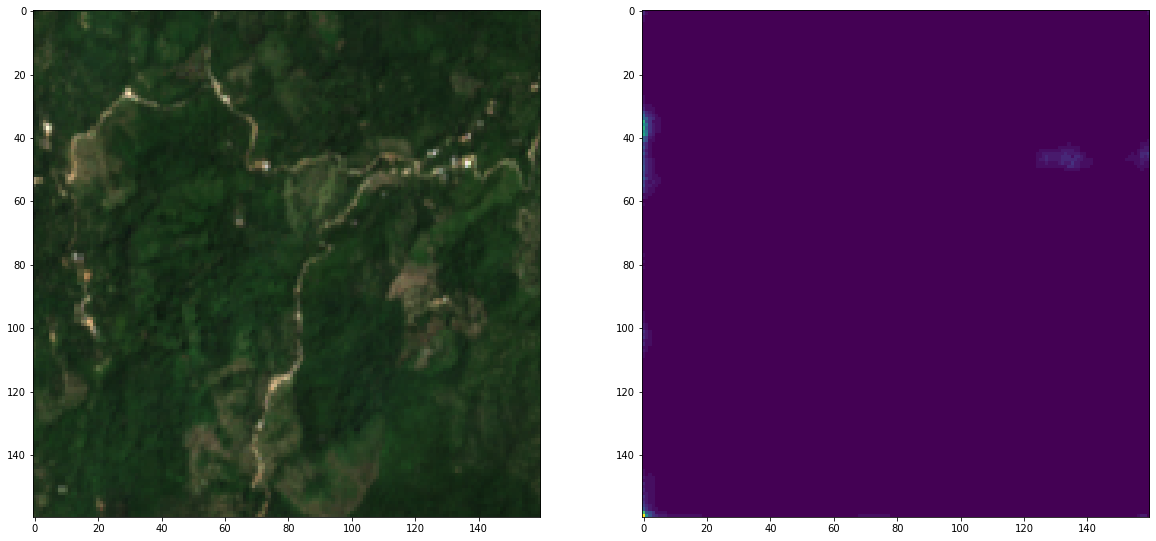

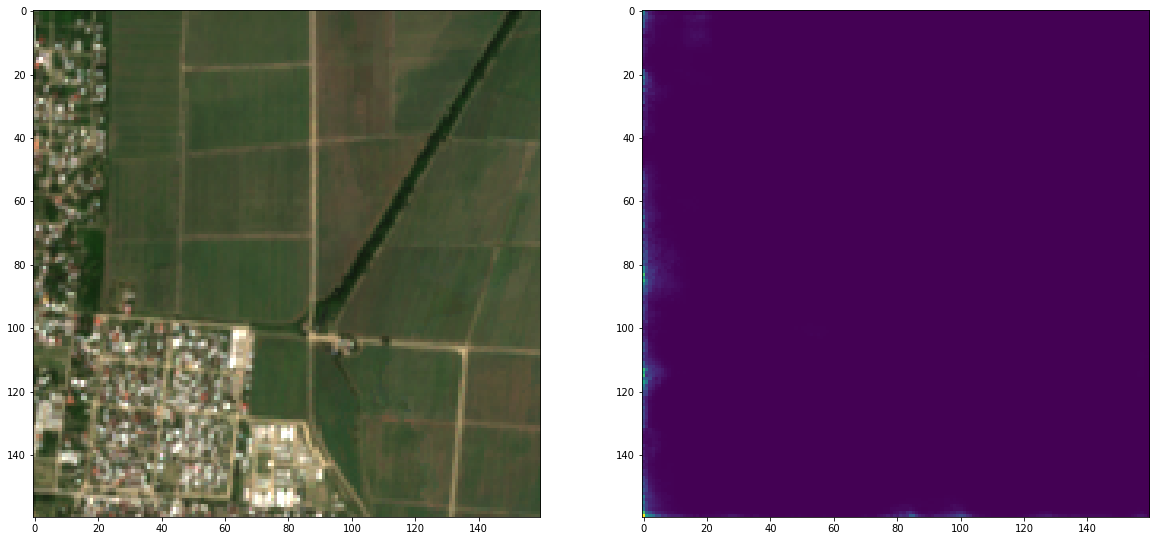

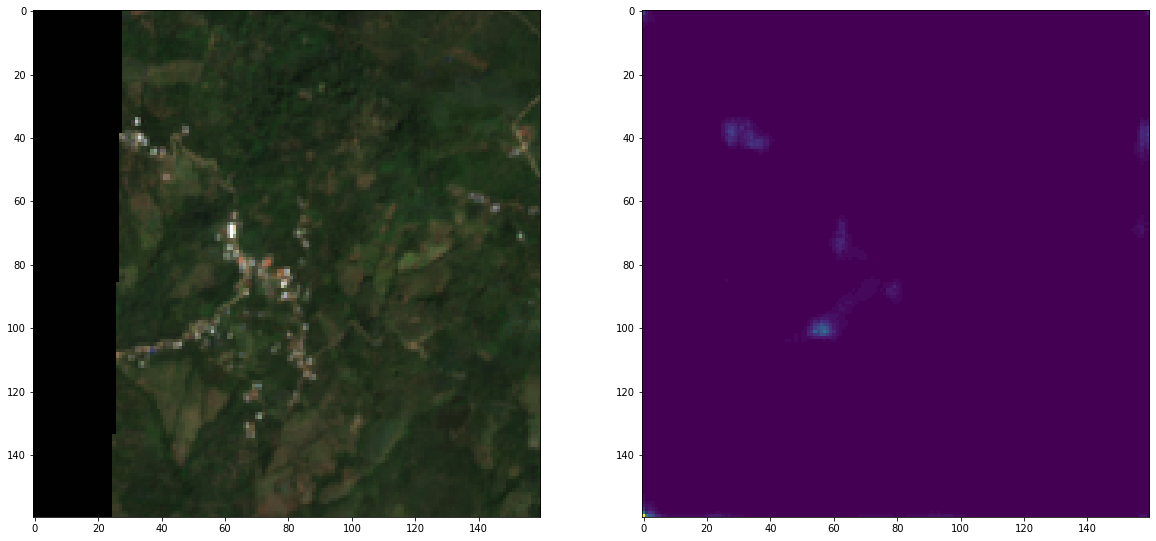

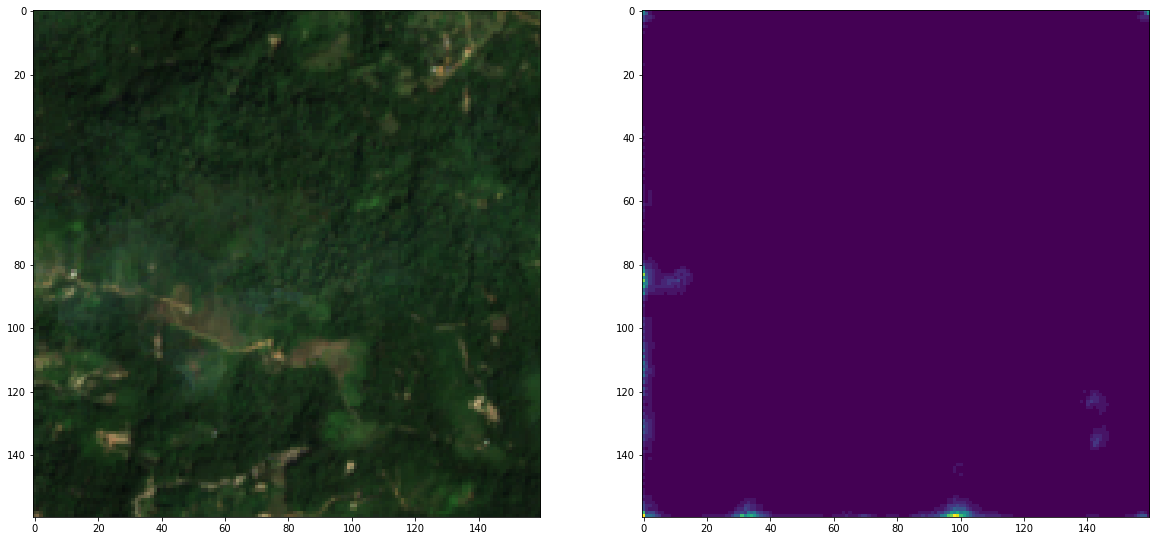

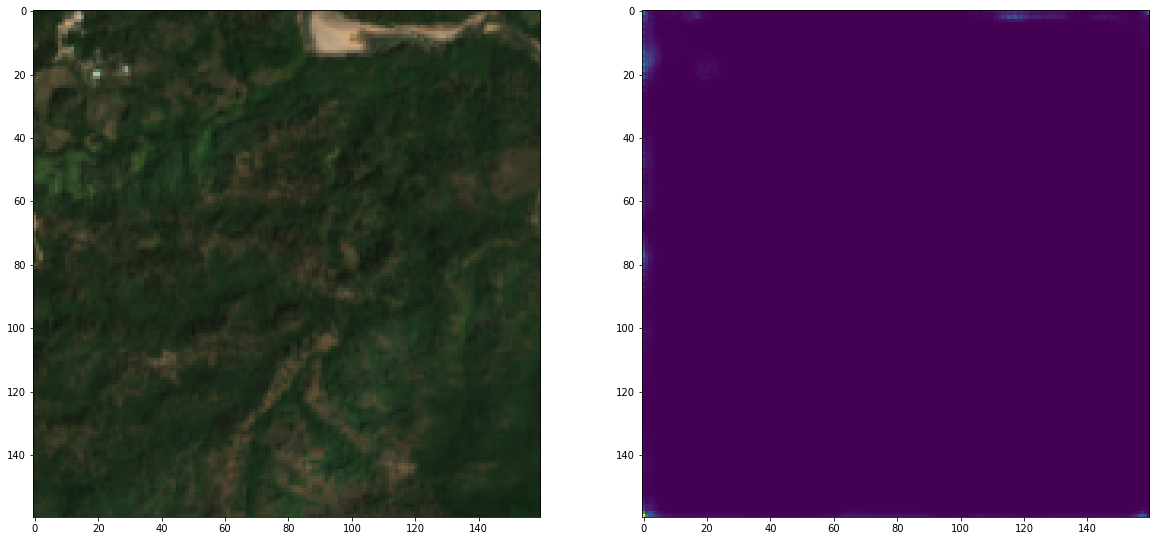

In [37]:
plot_data_results(num_samples=5, fig_size=(2, 2), predict_config=predict_config, img_ch =2, n_bands=3)

Subida al bucket 

In [ ]:
results_folder=os.path.join(BASE_PATH,'dataset/data_results',ZONE,RESO,YEAR_PREDICT,VERSION,str(SIZE)+"_"+str(STEP_SIZE))

BUCKET_RESULTS= f'gs://dym-quilmes-trucks-temp/I2UD/results_L1/{ZONE}/{RESO}/{VERSION}/poligonize/{str(SIZE)}_{str(STEP_SIZE)}/'

!gsutil -m cp -r $RESULTS_folder $BUCKET_RESULTS

# Post procesamiento 3 clases

En esta etapa se aplican los siguientes métodos de post-procesamiento a los resultados de la predicción realizada por el modelo:

* Filtrado por umbral
* Poligonizado

## Filtrado por umbral
En este proceso se realiza un filtrado de las imágenes mediante la aplicación de un umbral sobre los valores de los rásteres, que en este caso representan la probabilidad (valores entre 0 y 1), quedandonos así con las de mayor precisión.

In [9]:
!pip install tqdm

### Post-process for Tegucigalpa

In [18]:
os.path.join(BASE_PATH,'dataset/data_results',ZONE,RESO,YEAR_PREDICT,VERSION,'temp_postprocesamiento',str(SIZE)+"_"+str(STEP_SIZE))

'./../dataset/data_results/tegu/low/2020/v3/temp_postprocesamiento/160_20'

In [22]:
#Post-process for Tegucigalpa
#thr = THR

if N_CLASSES==3:

    results_path_ =os.path.join(BASE_PATH,'dataset/data_results',ZONE,RESO,YEAR_PREDICT,VERSION,str(SIZE)+"_"+str(STEP_SIZE))
    if DEBUG: print (results_path_)

    dest = os.path.join(BASE_PATH,'dataset/data_results',ZONE,RESO,YEAR_PREDICT,VERSION,'temp_postprocesamiento',str(SIZE)+"_"+str(STEP_SIZE)) # ruta de destino para nuestra predicción
    if DEBUG: print (dest)

    files = next(os.walk(results_path_))[2]
    new_dir = os.path.join(dest, '1band_3classes','thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C)+'/')
    os.makedirs(new_dir, exist_ok=True)
    if DEBUG: print (new_dir)
    for file in files:
        if os.path.splitext(file)[-1]=='xml': continue

        result_dst = os.path.join(results_path_,file)
        output_tif_path = os.path.join(dest, '1band_3classes','thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C), file)
        exp = "((B<"+str(threshold_B)+")*(C<"+str(threshold_C)+")*(A >"+str(threshold_A)+")*199 ) + ((C<"+str(threshold_C)+")*(B >"+str(threshold_B)+")*99 )+((B<"+str(threshold_B)+")*(C >"+str(threshold_C)+")*254 ) +1"
        cmd_calc = f'gdal_calc.py -A {result_dst} --A_band=1 -B {result_dst} --B_band=2 -C {result_dst} --C_band=3 --outfile {output_tif_path} --calc="{exp}" --NoDataValue=0'
        subprocess.run(cmd_calc, shell=True)
        print("--",output_tif_path)
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")    
    output_vrt = os.path.join(dest, '1band_3classes','thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C),'tiles.vrt')
    output_tif = os.path.join(dest, '1band_3classes','thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C),'*.tif')
    cmd_buildvrt = f'gdalbuildvrt {output_vrt} {output_tif}'
    subprocess.run(cmd_buildvrt, shell=True)
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>") 
    #recortamos el vrt
    #zona_grilla= './../data/tegu/planet/shp/aoi_tegu_grilla.geojson'
    #grilla_vrt=os.path.join(dest, '1band_3classes','thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C),'*_grilla.tif')
    #cmd_clip_raster = f"gdalwarp -cutline {zona_grilla} -crop_to_cutline -dstalpha {output_vrt} {grilla_vrt}"
    #subprocess.run(cmd_clip_raster, shell=True)
    #print('-----',grilla_vrt)
    output_shp_path = os.path.join('../dataset/data_results',ZONE,RESO,YEAR_PREDICT,VERSION,'poligonize', 'poligonize_classABC_thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C)+'_'+ZONE+'_'+YEAR+'_'+RESO+'_'+str(SIZE)+'_'+str(STEP_SIZE)+'_'+'.gpkg')
    cmd_polygonize = f'gdal_polygonize.py {output_vrt} {output_shp_path}'
    subprocess.run(cmd_polygonize, shell=True)

#if N_CLASSES==1:

 #   str_thr = str(int(thr *10))

  #  input_path =  predict_config.results_path
   # output_file = os.path.join(BASE_PATH,f'dataset/data_results/tegu/poligonize_thr_{str_thr}_{ZONE}_{RESO}_{YEAR_PREDICT}_{str(SIZE)}_{str(STEP_SIZE)}_{INFO}.gpkg') # ruta de destino para nuestra predicción

    #polygonize(threshold=thr, input_dir=input_path, output=output_file)

./../dataset/data_results/tegu/low/2020/v3/160_20
./../dataset/data_results/tegu/low/2020/v3/temp_postprocesamiento/160_20
./../dataset/data_results/tegu/low/2020/v3/temp_postprocesamiento/160_20/1band_3classes/thr_130_130_200/
0.. 10.. 20.. 30.. 40.. 50.. 60.. 70.. 80.. 90.. 100 - Done
-- ./../dataset/data_results/tegu/low/2020/v3/temp_postprocesamiento/160_20/1band_3classes/thr_130_130_200/0000000000-0000000000_0_13.tif
0.. 10.. 20.. 30.. 40.. 50.. 60.. 70.. 80.. 90.. 100 - Done
-- ./../dataset/data_results/tegu/low/2020/v3/temp_postprocesamiento/160_20/1band_3classes/thr_130_130_200/0000000000-0000000000_2_11.tif
0.. 10.. 20.. 30.. 40.. 50.. 60.. 70.. 80.. 90.. 100 - Done
-- ./../dataset/data_results/tegu/low/2020/v3/temp_postprocesamiento/160_20/1band_3classes/thr_130_130_200/0000000000-0000000000_11_11.tif
0.. 10.. 20.. 30.. 40.. 50.. 60.. 70.. 80.. 90.. 100 - Done
-- ./../dataset/data_results/tegu/low/2020/v3/temp_postprocesamiento/160_20/1band_3classes/thr_130_130_200/0000000000

In [16]:
    output_shp_path = os.path.join('./../dataset/data_results/sula/low/2021/poligonize', 'poligonize_classABC_thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C)+'_'+ZONE+'_'+YEAR_PREDICT+'_'+VERSION+'_'+str(SIZE)+'_'+str(STEP_SIZE)+'_'+'.gpkg')
    cmd_polygonize = f'gdal_polygonize.py {output_vrt} {output_shp_path}'
    subprocess.run(cmd_polygonize, shell=True)

0...10...20...30...40...50...60...70...80...90...Creating output ./../dataset/data_results/sula/low/2021/poligonize/poligonize_classABC_thr_130_50_50_sula_2021_tegu_on_sula_130_40_.gpkg of format GPKG.
100 - done.


CompletedProcess(args='gdal_polygonize.py ./../dataset/data_results/sula/low/2021/temp_postprocesamiento/130_40/1band_3classes/thr_130_50_50/tiles.vrt ./../dataset/data_results/sula/low/2021/poligonize/poligonize_classABC_thr_130_50_50_sula_2021_tegu_on_sula_130_40_.gpkg', returncode=0)

Subida al bucket

In [23]:
poligonize_folder=f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/poligonize/*.gpkg'

BUCKET_POLIG_RESULTS= 'gs://dym-quilmes-trucks-temp/I2UD/results_L1/tegu/planet/v2/poligonize/'

!gsutil -m cp -r $poligonize_folder $BUCKET_POLIG_RESULTS

Copying file://./../dataset/data_results/tegu/planet/2022/poligonize/poligonize_classABC_thr_50_15_15_tegu_2022_planet_256_70_.gpkg [Content-Type=application/octet-stream]...
| [1/1 files][100.6 MiB/100.6 MiB] 100% Done                                    
Operation completed over 1 objects/100.6 MiB.                                    


### Filtro de area minima Tegucigalpa

In [14]:


glob.glob(os.path.join(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/poligonize/poligonize_classABC_thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C)+'_'+ZONE+'_'+YEAR+'_'+RESO+'_'+str(SIZE)+'_'+str(STEP_SIZE)+'_'+'.gpkg'))

['./../dataset/data_results/tegu/low/2020/v3/poligonize/poligonize_classABC_thr_130_130_200_tegu_2020_low_160_20_.gpkg']

In [15]:

polig_folder=glob.glob(os.path.join(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/poligonize/*.gpkg'))

for file in polig_folder:
                       src_file =file
                       dst_file = file[:-5] + '_utm.gpkg'
                       !ogr2ogr -s_srs EPSG:4326 -t_srs EPSG:32616 -f 'GPKG' $dst_file $src_file
                       print('<<<<<<<<<<<<',dst_file)

<<<<<<<<<<<< ./../dataset/data_results/tegu/low/2020/v3/poligonize/poligonize_classABC_thr_130_130_200_tegu_2020_low_160_20__utm.gpkg


In [12]:
!ogrinfo -al -so './../dataset/data_results/tegu/planet/2022/poligonize/poligonize_classABC_thr_130_130_200_tegu_2022_planet_256_70__utm.gpkg' | head -n25

INFO: Open of `./../dataset/data_results/tegu/planet/2022/poligonize/poligonize_classABC_thr_130_130_200_tegu_2022_planet_256_70__utm.gpkg'
      using driver `GPKG' successful.

Layer name: out
Geometry: Polygon
Feature Count: 43016
Extent: (466083.361442, 1545118.657740) - (488116.068300, 1565115.654891)
Layer SRS WKT:
PROJCRS["WGS 84 / UTM zone 16N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 16N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-87,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],


In [18]:
min_area=5000

In [19]:
input_path =os.path.join(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/poligonize/*utm.gpkg')

output_path =  f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/poligonize/poligonize_classABC_thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C)+'_'+ZONE+'_'+YEAR+'_'+RESO+'_'+str(SIZE)+'_'+str(STEP_SIZE)+'_utm_up'+str(min_area)+'.gpkg'

!ogr2ogr \
    -t_srs EPSG:32616 \
    -f "GPKG" \
    -sql "SELECT * FROM out m WHERE (ST_Area(geom) > $min_area)" \
    -dialect SQLITE \
    -nln results \
    $output_path \
    $input_path

### Post-process for Sula

Creamos un archivo de texto con los .tif de prediccion para crear un .vrt con ellos

In [16]:
ZONE= 'sula'
YEAR_PREDICT='2021'
RESO='low'
VERSION='tegu_on_sula'
SIZE=130
STEP_SIZE=40
BASE_PATH='./..'

In [17]:
new_dir=os.path.join('./../dataset/data_results',ZONE,RESO,YEAR_PREDICT,VERSION,'temp_postprocesamiento/')
os.makedirs(new_dir, exist_ok=True) 
vrt_path        =  os.path.join('./../dataset/data_results',ZONE,RESO,YEAR_PREDICT,VERSION,'temp_postprocesamiento','tiles.vrt') # ruta de destino para nuestra predicción
predict_results = os.path.join(BASE_PATH,'dataset/data_results',ZONE,RESO,YEAR_PREDICT,VERSION,str(SIZE)+"_"+str(STEP_SIZE),'*.tif') # ruta de destino para nuestra predicción
                                                                                                  

filenames = glob.glob(predict_results)
#print(filenames)
with open('tmp_list.txt', 'w') as f:
    for line in filenames:
        f.write(line)
        f.write('\n')

!gdalbuildvrt -input_file_list tmp_list.txt $vrt_path

0...10...20...30...40...50...60...70...80...90...100 - done.


In [1]:
#!pip install geopandas

Recortamos el .vrt segun cada municipio del valle de sula

In [14]:
aoi_folder=BASE_PATH + f'data/{ZONE}/{RESO}/shp/'
BUCKET_AOI='gs://dym-quilmes-trucks-temp/I2UD/asentamientos_informales/data/shp/municipios_valle_sula.geojson'

!gsutil -m cp -r $BUCKET_AOI $aoi_folder

Copying gs://dym-quilmes-trucks-temp/I2UD/asentamientos_informales/data/shp/municipios_valle_sula.geojson...
/ [1/1 files][  9.0 MiB/  9.0 MiB] 100% Done                                    
Operation completed over 1 objects/9.0 MiB.                                      


In [21]:
!pip install geopandas 

     |████████████████████████████████| 1.0 MB 15.8 MB/s eta 0:00:01
     |████████████████████████████████| 11.7 MB 65.1 MB/s eta 0:00:01


In [19]:
import geopandas as gpd

gdf = gpd.read_file(f'{BASE_PATH}data/{ZONE}/{RESO}/shp/municipios_valle_sula.geojson')
path_vrt = vrt_path
new_dir=os.path.join("./../dataset/data_results",ZONE,RESO,YEAR_PREDICT,VERSION,'temp_postprocesamiento','municipios/')
os.makedirs(new_dir, exist_ok=True)

for i, muni in gdf.iterrows():
    muni_name = muni['ADM2_ES']
    muni_vec = f"./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/temp_postprocesamiento/municipios/{muni_name}.geojson"
    muni_raster = f"./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/temp_postprocesamiento/municipios/{muni_name}.tif"
    gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
   #recorto
    cmd_clip_raster = f"gdalwarp -cutline {muni_vec} -crop_to_cutline -dstalpha {path_vrt} {muni_raster}"
    subprocess.run(cmd_clip_raster, shell=True)
    print(muni_raster)

/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 3854P x 4705L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Tela.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 2788P x 3655L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Puerto_Cortes.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 12P x 14L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Arizona.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 2349P x 1999L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Omoa.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 3556P x 2442L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Choloma.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 2817P x 5580L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/El_Progreso.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 2307P x 5631L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/El_Negrito.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 3591P x 2853L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/San_Pedro_Sula.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1838P x 2074L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/La_Lima.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 317P x 590L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Quimistan.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1146P x 4535L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Yoro.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 2122P x 3852L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Morazan.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1642P x 1624L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/San_Manuel.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 863P x 752L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Chinda.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 153P x 189L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Trinidad.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 2080P x 2085L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/San_Antonio_de_Cortes.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 3671P x 4388L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Santa_Cruz_de_Yojoa.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 3370P x 3517L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Victoria.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 510P x 1116L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/San_Luis.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 2765P x 3234L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/La_Libertad.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1041P x 1249L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Concepcion_del_Sur.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 2442P x 2752L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Meambar.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1662P x 1289L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Taulabe.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1436P x 2640L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Minas_de_Oro.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1877P x 978L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/San_Pedro_Zacapa.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 2239P x 1574L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Ojos_de_Agua.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 170P x 776L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Ceguaca.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1189P x 824L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Siguatepeque.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 2230P x 2489L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Villanueva.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 536P x 1328L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Petoa.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1213P x 793L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Pimienta.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1299P x 1502L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Concepcion_del_Norte.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1311P x 1565L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Potrerillos.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 2218P x 1149L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Santa_Rita.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1709P x 1249L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Ilama.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1372P x 1193L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/San_Francisco_de_Yojoa.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 689P x 675L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Gualala.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1476P x 1536L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Santa_Barbara.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1678P x 926L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Las_Lajas.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 1432P x 1343L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Las_Vegas.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 306P x 349L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/San_Francisco_de_Ojuera.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 428P x 269L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/Esquias.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 761P x 328L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/San_Jose_de_Comayagua.tif


/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/tmp/ipykernel_170/3574168566.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoDataFrame(geometry=list(muni.geometry)).to_file(muni_vec)
/home/cdsw/.local/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Creating output file that is 620P x 72L.
Processing ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image ./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/tiles.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
./../dataset/data_results/sula/low/2021/v6/temp_postprocesamiento/municipios/La_Trinidad.tif


In [18]:
vrt_path


'./../dataset/data_results/sula/planet/2022/temp_postprocesamiento/v5/tiles.vrt'

### Umbral
Aplicamos **umbral** a la probabilidad, para cada municipio

In [21]:
THR=0.2
thr=str(int(THR*10))
thr

'2'

In [21]:
thr=str(int(THR*10))
path_municipios_tif=glob.glob(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/temp_postprocesamiento/municipios/*.tif')
new_dir=f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/temp_postprocesamiento/th0{thr}/'
os.makedirs(new_dir, exist_ok=True)
thr1=str(int(THR*255))
for i in path_municipios_tif: 
    base=os.path.basename(i)
    result_input = os.path.join(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/temp_postprocesamiento/municipios',base)
    output_tif_path =os.path.join(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/temp_postprocesamiento/th0{thr}',base)
    exp = "((A >"+thr1+")*200)"
    cmd_calc = f'gdal_calc.py -A {result_input} --A_band=1 --outfile {output_tif_path} --calc="{exp}" --NoDataValue=0'
    subprocess.run(cmd_calc, shell=True)
    print(cmd_calc)
    print("--",output_tif_path)
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<") 

0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 14.. 14.. 14.. 14.. 14.. 15.. 15.. 15.. 15.. 15.. 16.. 16.. 16.. 16.. 16.. 17.. 17.. 17.. 17.. 17.. 18.. 18.. 18.. 18.. 18.. 18.. 19.. 19.. 19.. 19.. 19.. 20.. 20.. 20.. 20.. 20.. 21.. 21.. 21.. 21.. 21.. 22.. 22.. 22.. 22.. 22.. 22.. 23.. 23.. 23.. 23.. 23.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 26.. 26.. 26.. 26.. 26.. 27.. 27.. 27.. 27.. 27.. 27.. 28.. 28.. 28.. 28.. 28.. 29.. 29.. 29.. 29.. 29.. 30.. 30.. 30.. 30.. 30.. 31.. 31.. 31.. 31.. 31.. 31.. 32.. 32.. 32.. 32.. 32.. 33.. 33.. 33.. 33.. 33.. 34.. 34.. 34.. 34.. 34.. 35.. 35.. 35.. 35.. 35.. 36.. 36.. 36.. 36.. 36.. 36.. 37.. 37.. 37.. 37.. 37.. 38.. 38.. 38.. 38.. 38.. 39.. 39.. 39.. 39.. 39.. 40.. 40.

Poligonizamos por municipio

In [22]:
#poligonizo
thr_path=glob.glob(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/temp_postprocesamiento/th0{thr}/*.tif')
new_dir=os.path.join(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/poligonize/th0{thr}/')
os.makedirs(new_dir, exist_ok=True)

for j in thr_path:
    base3=os.path.basename(j[:-4])
    base2=os.path.basename(j)
    result_thr=os.path.join(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/temp_postprocesamiento/th0{thr}',base2)
    output_shp_path = os.path.join(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/poligonize/th0{thr}', f"poligonize_classA_thr_0{thr}_{ZONE}_{RESO}_{YEAR_PREDICT}_{str(SIZE)}_{str(STEP_SIZE)}_{base3}.gpkg")
    cmd_polygonize = f'gdal_polygonize.py {result_thr} {output_shp_path}'
    subprocess.run(cmd_polygonize, shell=True)
    print("---",output_shp_path)

0...10...20...30...40...50...60...70...80...90...Creating output ./../dataset/data_results/sula/low/2021/v6/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_160_40_Potrerillos.gpkg of format GPKG.
100 - done.
--- ./../dataset/data_results/sula/low/2021/v6/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_160_40_Potrerillos.gpkg
0...10...20...30...40...50...60...70...80...90...Creating output ./../dataset/data_results/sula/low/2021/v6/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_160_40_Minas_de_Oro.gpkg of format GPKG.
100 - done.
--- ./../dataset/data_results/sula/low/2021/v6/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_160_40_Minas_de_Oro.gpkg
0...10...20...30...40...50...60...70...80...90...Creating output ./../dataset/data_results/sula/low/2021/v6/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_160_40_Trinidad.gpkg of format GPKG.
100 - done.
--- ./../dataset/data_results/sula/low/2021/v6/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_16

**Subida al bucket**

In [20]:
poligonize_folder=f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/poligonize/{VERSION}/*.gpkg'
BUCKET_POLIG_RESULTS= 'gs://dym-quilmes-trucks-temp/I2UD/results_L1/sula/planet/v4/poligonize/'

!gsutil -m cp -r $poligonize_folder $BUCKET_POLIG_RESULTS

Copying file://./../dataset/data_results/sula/planet/2022/poligonize/v4/poligonize_classA_thr_05_sula_planet_2022_130_40_Arizona.gpkg [Content-Type=application/octet-stream]...
Copying file://./../dataset/data_results/sula/planet/2022/poligonize/v4/poligonize_classA_thr_05_sula_planet_2022_130_40_Ceguaca.gpkg [Content-Type=application/octet-stream]...
Copying file://./../dataset/data_results/sula/planet/2022/poligonize/v4/poligonize_classA_thr_05_sula_planet_2022_130_40_Chinda.gpkg [Content-Type=application/octet-stream]...
Copying file://./../dataset/data_results/sula/planet/2022/poligonize/v4/poligonize_classA_thr_05_sula_planet_2022_130_40_Choloma.gpkg [Content-Type=application/octet-stream]...
Copying file://./../dataset/data_results/sula/planet/2022/poligonize/v4/poligonize_classA_thr_05_sula_planet_2022_130_40_Concepcion_del_Norte.gpkg [Content-Type=application/octet-stream]...
Copying file://./../dataset/data_results/sula/planet/2022/poligonize/v4/poligonize_classA_thr_05_sula_p

### Filtro área mínima para sula

In [25]:
import glob
polig_folder=glob.glob(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/poligonize/th0{thr}/*.gpkg')
for file in polig_folder:
                       src_file =file
                       dst_file = file[:-5] + '_utm.gpkg'
                       !ogr2ogr -s_srs EPSG:4326 -t_srs EPSG:32616 -f 'GPKG' $dst_file $src_file
                       print('<<<<<<<<<<<<',dst_file)

<<<<<<<<<<<< ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_130_40_Gualala_utm.gpkg
<<<<<<<<<<<< ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_130_40_Chinda_utm.gpkg
<<<<<<<<<<<< ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_130_40_Pimienta_utm.gpkg
<<<<<<<<<<<< ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_130_40_Villanueva_utm.gpkg
<<<<<<<<<<<< ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_130_40_La_Lima_utm.gpkg
<<<<<<<<<<<< ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_130_40_Minas_de_Oro_utm.gpkg
<<<<<<<<<<<< ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/poligonize_classA_thr_02_sula_low_2021_1

In [26]:
#tegu on sula
polig_folder=glob.glob(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/poligonize/th0{thr}/*_utm.gpkg')
min_area2=3000
new_dir=os.path.join('./../dataset/data_results',ZONE,RESO,YEAR_PREDICT,VERSION,'poligonize',f'th0{thr}','min_area/')
os.makedirs(new_dir, exist_ok=True)

for utm_file in polig_folder:
    input_path =utm_file
    muni_name=os.path.basename(utm_file[:-5])
    output_path =  f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/{VERSION}/poligonize/th0{thr}/min_area/{muni_name}_up_3000.gpkg'

    !ogr2ogr \
        -t_srs EPSG:32720 \
        -f "GPKG" \
        -sql "SELECT * FROM out m WHERE (ST_Area(geom) > $min_area2)" \
        -dialect SQLITE \
        -nln results \
        $output_path \
        $input_path
    print(">>>>>>>>",output_path)

>>>>>>>> ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/min_area/poligonize_classA_thr_02_sula_low_2021_130_40_San_Francisco_de_Yojoa_utm_up_3000.gpkg
>>>>>>>> ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/min_area/poligonize_classA_thr_02_sula_low_2021_130_40_Siguatepeque_utm_up_3000.gpkg
>>>>>>>> ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/min_area/poligonize_classA_thr_02_sula_low_2021_130_40_Las_Lajas_utm_up_3000.gpkg
>>>>>>>> ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/min_area/poligonize_classA_thr_02_sula_low_2021_130_40_San_Pedro_Zacapa_utm_up_3000.gpkg
>>>>>>>> ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/min_area/poligonize_classA_thr_02_sula_low_2021_130_40_San_Francisco_de_Ojuera_utm_up_3000.gpkg
>>>>>>>> ./../dataset/data_results/sula/low/2021/tegu_on_sula/poligonize/th02/min_area/poligonize_classA_thr_02_sula_low_2021_130_40_Tela_utm_up_3000.gpkg
>>>>>>>>

In [34]:
polig_folder=glob.glob(f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/poligonize/{VERSION}/th0{thr}/*_utm.gpkg')
min_area2=3000
new_dir=os.path.join('./../dataset/data_results',ZONE,RESO,YEAR_PREDICT,'poligonize',VERSION,f'th0{thr}','min_area/')
os.makedirs(new_dir, exist_ok=True)

for utm_file in polig_folder:
    input_path =utm_file
    muni_name=os.path.basename(utm_file[:-5])
    output_path =  f'./../dataset/data_results/{ZONE}/{RESO}/{YEAR_PREDICT}/poligonize/{VERSION}/th0{thr}/min_area/{muni_name}_up_3000.gpkg'

    !ogr2ogr \
        -t_srs EPSG:32720 \
        -f "GPKG" \
        -sql "SELECT * FROM out m WHERE (ST_Area(geom) > $min_area2)" \
        -dialect SQLITE \
        -nln results \
        $output_path \
        $input_path
    print(">>>>>>>>",output_path)


>>>>>>>> ./../dataset/data_results/sula/planet/2022/poligonize/v5/th02/min_area/poligonize_classA_thr_02_sula_planet_2022_256_70_Choloma_utm_up_3000.gpkg
>>>>>>>> ./../dataset/data_results/sula/planet/2022/poligonize/v5/th02/min_area/poligonize_classA_thr_02_sula_planet_2022_256_70_Santa_Cruz_de_Yojoa_utm_up_3000.gpkg
>>>>>>>> ./../dataset/data_results/sula/planet/2022/poligonize/v5/th02/min_area/poligonize_classA_thr_02_sula_planet_2022_256_70_La_Libertad_utm_up_3000.gpkg
>>>>>>>> ./../dataset/data_results/sula/planet/2022/poligonize/v5/th02/min_area/poligonize_classA_thr_02_sula_planet_2022_256_70_San_Manuel_utm_up_3000.gpkg
>>>>>>>> ./../dataset/data_results/sula/planet/2022/poligonize/v5/th02/min_area/poligonize_classA_thr_02_sula_planet_2022_256_70_Quimistan_utm_up_3000.gpkg
>>>>>>>> ./../dataset/data_results/sula/planet/2022/poligonize/v5/th02/min_area/poligonize_classA_thr_02_sula_planet_2022_256_70_La_Trinidad_utm_up_3000.gpkg
>>>>>>>> ./../dataset/data_results/sula/planet/2022

**Subida al bucket**

In [35]:
poligonize_folder=os.path.join('./../dataset/data_results',ZONE,RESO,YEAR_PREDICT,'poligonize',VERSION,f'th0{thr}','min_area/*.gpkg')
BUCKET_MINAREA_RESULTS= f'gs://dym-quilmes-trucks-temp/I2UD/results_L1/{ZONE}/{VERSION}/min_area/'

!gsutil -m cp -r $poligonize_folder $BUCKET_MINAREA_RESULTS

Copying file://./../dataset/data_results/sula/planet/2022/poligonize/v5/th02/min_area/poligonize_classA_thr_02_sula_planet_2022_256_70_Arizona_utm_up_3000.gpkg [Content-Type=application/octet-stream]...
Copying file://./../dataset/data_results/sula/planet/2022/poligonize/v5/th02/min_area/poligonize_classA_thr_02_sula_planet_2022_256_70_Chinda_utm_up_3000.gpkg [Content-Type=application/octet-stream]...
Copying file://./../dataset/data_results/sula/planet/2022/poligonize/v5/th02/min_area/poligonize_classA_thr_02_sula_planet_2022_256_70_Choloma_utm_up_3000.gpkg [Content-Type=application/octet-stream]...
Copying file://./../dataset/data_results/sula/planet/2022/poligonize/v5/th02/min_area/poligonize_classA_thr_02_sula_planet_2022_256_70_Ceguaca_utm_up_3000.gpkg [Content-Type=application/octet-stream]...
Copying file://./../dataset/data_results/sula/planet/2022/poligonize/v5/th02/min_area/poligonize_classA_thr_02_sula_planet_2022_256_70_Ilama_utm_up_3000.gpkg [Content-Type=application/octet

In [52]:
ls './../data/'

sula/  weights/
